In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup
import pandas as pd
import os
import html
import re

BASE_PATH = os.getcwd() + "/Data"

BEST_MODEL_PATH = "%s\\best_model.pt" % (BASE_PATH)

ALL_FILE_PATH = BASE_PATH + "/all.txt"
COSINE_SCORE_PATH = BASE_PATH + "/cosine_similarity.csv"

TRAIN_FILE_SRC_ORIG = BASE_PATH + "/wiki.full.aner.ori.train.src"
TRAIN_FILE_DST_ORIG = BASE_PATH + "/wiki.full.aner.ori.train.dst"
VALID_FILE_DST_ORIG = BASE_PATH + "/wiki.full.aner.ori.valid.dst"
VALID_FILE_SRC_ORIG = BASE_PATH + "/wiki.full.aner.ori.valid.src"
TEST_FILE_DST_ORIG = BASE_PATH + "/wiki.full.aner.ori.test.dst"
TEST_FILE_SRC_ORIG = BASE_PATH + "/wiki.full.aner.ori.test.src"
TRAIN_FILE_SRC = BASE_PATH + "/train.src"
TRAIN_FILE_DST = BASE_PATH + "/train.dst"
VALID_FILE_DST = BASE_PATH + "/valid.dst"
VALID_FILE_SRC = BASE_PATH + "/valid.src"
TEST_FILE_DST = BASE_PATH + "/test.dst"
TEST_FILE_SRC = BASE_PATH + "/test.src"

SPM_MODEL_PATH = BASE_PATH + "/spm.model"
SPM_VOCAB_PATH = BASE_PATH + "/spm.vocab"

MAX_LENGTH = 126

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Found device type: {DEVICE}")
    

Found device type: cuda


**Preprocessing**

In [33]:
def clean_line(line):
    # Převede HTML entity na jejich znaky (např. &ndash; → –)
    s = html.unescape(line)
    
    # Nahrazení -LRB-/-RRB- závorkami
    s = s.replace("-LRB-", "(").replace("-RRB-", ")")
    
    # Odstranění závorek s nesmyslným obsahem (např. "( , ; , ; )")
    s = re.sub(r'\(\s*[,;:.!? ]+\s*\)', '', s)        
    s = s.lower()
    s = re.sub(r"[^a-z0-9 .!?]", "", s)
    s = s.strip() + "\n"
    return s

if not os.path.isfile(ALL_FILE_PATH):
    with open(TRAIN_FILE_SRC_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines = lines
        file.close()
    with open(TRAIN_FILE_SRC, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()
        
    with open(TRAIN_FILE_DST_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines += lines
        file.close()
    with open(TRAIN_FILE_DST, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()
        
    with open(VALID_FILE_SRC_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines += lines
        file.close()
    with open(VALID_FILE_SRC, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()

    with open(VALID_FILE_DST_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines += lines
        file.close()
    with open(VALID_FILE_DST, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()

    with open(TEST_FILE_DST_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines += lines
        file.close()
    with open(TEST_FILE_DST, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()

    with open(TEST_FILE_SRC_ORIG, "r", encoding="utf-8") as file:
        lines = [clean_line(line.strip()) for line in file.readlines()]
        all_lines += lines
        file.close()
    with open(TEST_FILE_SRC, "w", encoding="utf-8") as file:
        file.writelines(lines)
        file.close()

    with open(ALL_FILE_PATH, "w", encoding="utf-8") as file:
        file.writelines(all_lines)
        file.close()

**Analýza datasetu**

In [34]:
from sentence_transformers import SentenceTransformer, util
from statistics import mean
import os
import pandas as pd

cosine_scores = []

if not os.path.isfile(COSINE_SCORE_PATH):
    st_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE.type)

    sentences_complex = open(TRAIN_FILE_SRC, encoding="utf-8").read().strip().split('\n')
    sentences_simple = open(TRAIN_FILE_DST, encoding="utf-8").read().strip().split('\n')

    
    for i, (c, s) in enumerate(zip(sentences_complex, sentences_simple)):
        emb_complex = st_model.encode(c, convert_to_tensor=True, batch_size=1)
        emb_simple = st_model.encode(s, convert_to_tensor=True, batch_size=1)
        score = torch.nn.functional.cosine_similarity(emb_complex.unsqueeze(0), emb_simple.unsqueeze(0))
        cosine_scores.append(score.item())
        # print(f"Pair {i+1}:")
        # print(f"  Complex: {c}")
        # print(f"  Simple:  {s}")
        # print(f"  Cosine similarity: {score.item():.4f}\n")
    
    with open(COSINE_SCORE_PATH, "w", encoding="utf-8") as file:
        file.writelines([f"{score}\n" for score in cosine_scores])
else:
    with open(COSINE_SCORE_PATH, encoding="utf-8") as file:
        cosine_scores = [float(score) for score in file.read().strip().split('\n')]
    # df = pd.read_csv(COSINE_SCORE_PATH)
    # cosine_scores = df[0].tolist()
    print("Cosine similarity scores loaded from file.\n")        

print(f"Avg of cosine similarity: {sum(cosine_scores) / len(cosine_scores):.4f}")
print(f"Mean of cosine similarity: {mean(cosine_scores):.4f}\n")

Avg of cosine similarity: 0.7100
Mean of cosine similarity: 0.7100



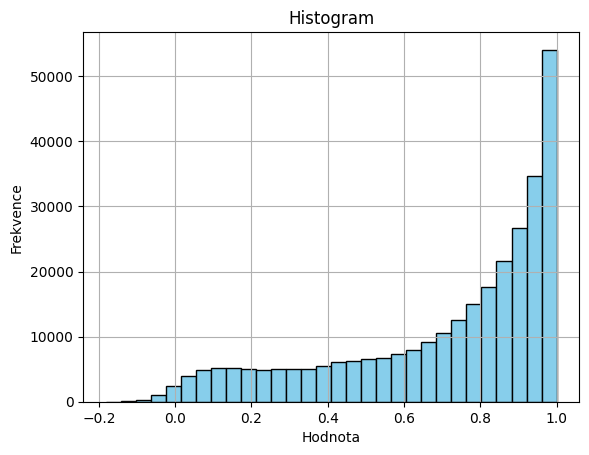

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(cosine_scores, columns=["cosine_similarity"])
df.to_csv("cosine_similarity.csv", index=False)
data = cosine_scores

plt.hist(data, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')
plt.grid(True)
plt.show()

**Použití SentencePieces tokenizeru**

In [35]:
import sentencepiece as spm

if not os.path.isfile(SPM_MODEL_PATH) or not os.path.isfile(SPM_VOCAB_PATH):
    spm.SentencePieceTrainer.Train(
        input=ALL_FILE_PATH,
        model_prefix="Data/spm",
        vocab_size=24000,
        character_coverage=1.0
    )


**Maximalni delka tensoru**

In [36]:
sp = spm.SentencePieceProcessor()
sp.LoadFromFile(SPM_MODEL_PATH)


if MAX_LENGTH == 0:
    with open(ALL_FILE_PATH, "r", encoding="utf-8") as file:
        lengths = []
        lines = file.readlines()
        for line in lines:
            piece = sp.EncodeAsPieces(line)
            lengths.append(len(piece))

        MAX_LENGTH = max(lengths) + 2

print(f"Max length: {MAX_LENGTH}") # type: ignore

Max length: 126


In [44]:
class SimplificationDataset(torch.utils.data.Dataset):
    def __init__(self, src_lines, tgt_lines, sp_model, batch_size, shuffle, max_len=50):
        self.sp = sp_model
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        try:
            src = self.sp.encode(self.src_lines[idx], out_type=int)
            tgt = self.sp.encode(self.tgt_lines[idx], out_type=int)
        except Exception as e:
            print(f"Error encoding line {idx}: {e}")
            return

        src = src[:self.max_len]
        tgt = tgt[:self.max_len]

        src += [0] * (self.max_len - len(src))
        tgt += [0] * (self.max_len - len(tgt))

        return {
            'src': torch.tensor([self.sp.bos_id()] + src + [self.sp.eos_id()], dtype=torch.long),
            'tgt': torch.tensor([self.sp.bos_id()] + tgt + [self.sp.eos_id()], dtype=torch.long),
        }
    
    def get_data_loader(self):
        return torch.utils.data.DataLoader(self, self.batch_size, self.shuffle)

    
class SimplificationDatasetFactory:
    def __init__(self, sp_model, src_path, tgt_path, batch_size, shuffle, cosine_scores_path=None, max_items=0, max_len=50) -> None:
        self._src_path = src_path
        self._tgt_path = tgt_path
        self._max_items = max_items
        self._max_len = max_len
        self._sp_model = sp_model
        self._batch_size = batch_size
        self._shuffle = shuffle

        self._src_lines = open(src_path, encoding="utf-8").read().strip().split('\n')
        self._tgt_lines = open(tgt_path, encoding="utf-8").read().strip().split('\n')
        if cosine_scores_path is not None:
            cosine_scores = open(cosine_scores_path, encoding="utf-8").read().strip().split('\n')
            self._cosine_scores = [float(x) for x in cosine_scores]

    def create(self, min_cosine_score=None):
        if min_cosine_score is None or self._cosine_scores is None:
            src_lines = self._src_lines
            tgt_lines = self._tgt_lines
        else:
            src_lines = []
            tgt_lines = []
            for i, (src, tgt) in enumerate(zip(self._src_lines, self._tgt_lines)):
                if self._cosine_scores[i] <= min_cosine_score:
                    src_lines.append(src)
                    tgt_lines.append(tgt)

        return SimplificationDataset(src_lines, tgt_lines, self._sp_model, self._batch_size, self._shuffle)

**Encoder**

In [45]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout = 0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)        
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

    def forward(self, x):
        emb = self.embed(x)
        _, (h, c) = self.lstm(emb)
        return _, h, c
    
class EncoderWithAttention(Encoder):
    def forward(self, x):
        emb = self.embed(x)
        o, (h, c) = self.lstm(emb)
        return o, h, c

**Decoder**

In [46]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(            
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, h, c):
        emb = self.embed(x.unsqueeze(1))
        output, (h, c) = self.lstm(emb, (h, c))
        logits = self.fc(output.squeeze(1))
        return logits, h, c

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, hidden, encoder_outputs):
        # obvykle vezmeme poslední vrstvu a první směr, např. hidden[-1]
        # proto pro jednoduchost počítáme jen s posledním hidden state:
        #   vybereme hidden[-1]
        hidden = hidden[-1]
        
        # Spočítat skóre (batch, seq_len)
        attn_scores = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        # Softmax přes seq_len dimenzi
        attn_weights = F.softmax(attn_scores, dim=1)
        
        # Vážený součet encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context, attn_weights

    
class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(
            input_size=emb_dim + hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, input_token, hidden, cell, encoder_outputs):
        embedded = self.embedding(input_token).unsqueeze(1)
        context, attn_weights = self.attention(hidden, encoder_outputs)

        # Spojení embedding a contextu
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)

        # LSTM krok
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        output = output.squeeze(1)
        output = torch.cat((output, context), dim=1)

        output = self.fc(output)
        return output, hidden, cell, attn_weights

**Model**

In [47]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self._encoder = encoder
        self._decoder = decoder
        self._device = device

    @property 
    def encoder(self):
        return self._encoder
    
    @property 
    def decoder(self):
        return self._decoder
    
    @property 
    def device(self):
        return self._device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.size()
        vocab_size = self._decoder.fc.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self._device)

        h, c = self._encoder(src)
        input = tgt[:, 0]  # <sos>

        for t in range(1, tgt_len):
            output, h, c = self._decoder(input, h, c)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = tgt[:, t] if teacher_force else top1

        return outputs
    
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self._encoder = encoder
        self._decoder = decoder
        self._device = device

    @property 
    def encoder(self):
        return self._encoder
    
    @property 
    def decoder(self):
        return self._decoder
    
    @property 
    def device(self):
        return self._device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # batch_size, tgt_len = tgt.shape
        # vocab_size = self._decoder.fc.out_features
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        vocab_size = self._decoder.fc.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self._device)

        encoder_outputs, h, c = self._encoder(src)
        
        input = tgt[:, 0]  # <sos>

        for t in range(1, tgt_len):
            output, h, c, _ = self._decoder(input, h, c, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = tgt[:, t] if teacher_force else top1

        return outputs
    
    def inference(self, src, max_len=50, sos_token=1, eos_token=2):
        self.eval()
        batch_size = src.size(0)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, max_len, dtype=torch.long).to(self.device)
        logits = torch.zeros(batch_size, max_len, vocab_size).to(self.device)

        with torch.no_grad():
            encoder_outputs, (hidden, cell) = self.encoder(src)
            input_token = torch.LongTensor([sos_token] * batch_size).to(self.device)

            for t in range(max_len):
                output, hidden, cell, _ = self.decoder(input_token, hidden, cell, encoder_outputs)
                logit = output
                input_token = output.argmax(1)

                outputs[:, t] = input_token
                logits[:, t, :] = logit

                if (input_token == eos_token).all():
                    break

        return outputs, logits

**Tréning**

In [ ]:
import time
from datetime import timedelta

class EarlyStopping:
    def __init__(self, patience=5):
        self._patience = patience
        self._best_loss = 0.0000
        self._epochs_no_improve = 0
        self._stop = False
        
    def __call__(self, valid_loss):
        if valid_loss < self._best_loss:
            self._best_loss = valid_loss
            self._epochs_no_improve = 0
        else:
            self._epochs_no_improve += 1
            if self._epochs_no_improve >= self._patience:
                self._stop = True
        return self._stop
    
    def reset(self):
        self._best_loss = 0.0000
        self._epochs_no_improve = 0
        self._stop = False

class Train:
    def __init__(self, model, train_dataset_factory, valid_dataset, optimizer,criterion, device, path, scheduler=None, patience=5):
        self._model = model
        self._train_dataset_factory = train_dataset_factory
        self._valid_dataset = valid_dataset
        self._optimizer = optimizer
        self._criterion = criterion
        self._device = device
        self._path = path
        self._scheduler = scheduler
        self._early_stopping = EarlyStopping(patience=patience)
        self._train_data_loader = None
        
    def run(self, epochs):
        self._init_run()
        self._run_epochs(epochs)
    
    def _init_run(self):        
        self._model.train()
        self._total_loss = 0
        self._early_stopping.reset()
        self._train_data_loader = None

    def _set_train_dataloader(self, epoch):
        if self._train_data_loader is None:
            dataset = self._train_dataset_factory.create(max_cosine_score=None)
            self._train_data_loader = dataset.get_data_loader()
            return True

    def _run_epochs(self, epochs):
        best_loss = 0.0000
        best_epoch = 0
        
        for epoch in range(epochs):
            start_time = time.time()
            dataset_changed = self._set_train_dataloader(epoch)
            train_loss = self._epoch()            
            valid_loss = self._validate()
            end_time = time.time()
            duration = end_time - start_time            
            print(f"Epoch {epoch} duration {timedelta(seconds=int(duration))}:")
            print(f"\tTrain loss: {train_loss:.4f} \tValid loss: {valid_loss:.4f}")

            if valid_loss < best_loss or epoch == 0:
                best_loss = valid_loss
                best_epoch = epoch
                torch.save(self._model.state_dict(), self._get_filename())
                
            if dataset_changed:
                self._dataset_changed(epoch)
            
            if self._early_stopping(valid_loss):
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Finished with epoch {best_epoch} with validation loss {best_loss:.4f}")

        self._model.load_state_dict(torch.load(self._get_filename(), weights_only=True))
    
    def _dataset_changed(self, epoch):
        pass
        
    def _epoch(self):
        total_loss = 0.0000
        
        try:
            for batch in self._train_data_loader: # type: ignore
                src, tgt = batch["src"].to(self._device), batch["tgt"].to(self._device)
                self._optimizer.zero_grad()
                
                output = self._model(src, tgt)
                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt = tgt[:, 1:].reshape(-1)
                
                loss = self._criterion(output, tgt)
                loss.backward()
                self._optimizer.step()
                if self._scheduler is not None:
                    self._scheduler.step()
                total_loss += loss.item()
            return total_loss / len(self._train_data_loader) # type: ignore
        except Exception as e:
            print(f"Error during training: {e}")
    
    def _validate(self):
        self._model.eval()
        total_loss = 0.0000
        data_loader = self._valid_dataset.get_data_loader()
        with torch.no_grad():
            for batch in data_loader:
                src, tgt = batch["src"].to(self._device), batch["tgt"].to(self._device)
                output = self._model(src, tgt)
                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt = tgt[:, 1:].reshape(-1)
                loss = self._criterion(output, tgt)
                total_loss += loss.item()
        self._model.train()
        return total_loss / len(data_loader)
    
    def _get_filename(self):
        return "%s\\best_model.pt" % (self._path)
    
class TrainWithCurriculumLearning(Train):
    def __init__(self, model, train_dataset_factory, valid_dataset, optimizer, criterion, device, path, easy_koef=0.1, medium_koef=0.4, easy_cosine_score=0.85, medium_cosine_score=0.6, scheduler=None):
        super().__init__(model, train_dataset_factory, valid_dataset, optimizer, criterion, device, path, scheduler)
        self._easy_koef = easy_koef
        self._medium_koef = medium_koef
        self._easy_cosine_score = easy_cosine_score
        self._medium_cosine_score = medium_cosine_score
        
    def _run_epochs(self, epochs):
        self._split_cosine_score(epochs)
        super()._run_epochs(epochs)    
    
    def _dataset_changed(self, epoch):
        cosine_score = self._get_cosine_score(epoch)
        print (f"Dataset changed at epoch {epoch} for cosine score < {cosine_score} ")
        filename = "{self._path}\\model_epoch_{epoch}_and cosine score < {cosine_score}.pt"         
        torch.save(self._model.state_dict(), filename)
        
    def set_train_dataloader(self, epoch):
        if epoch in self._epochs_split:
            self._train_data_loader = None
            
        if self._train_data_loader is None:
            dataset = self._train_dataset_factory.create(
                min_cosine_score=self._get_cosine_score(epoch)
            )
            self._train_data_loader = dataset.get_data_loader()
            return True

    def _split_cosine_score(self, epochs):
        self._epochs_split = [round(epochs * self._easy_koef), round(epochs * self._medium_koef)]
    
    def _get_cosine_score(self, epoch):
        if epoch < self._epochs_split[0]:
            return self._easy_cosine_score
        elif epoch < self._epochs_split[1]:
            return self._medium_cosine_score
        else:
            return None

In [52]:
sp = spm.SentencePieceProcessor()
sp.LoadFromFile(SPM_MODEL_PATH)

EMB_DIM = 256 #512 #128
HIDDEN_DIM = 512 #256 #64

encoder = EncoderWithAttention(
    vocab_size=sp.GetPieceSize(),
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=2
)

decoder = DecoderWithAttention(
    vocab_size=sp.GetPieceSize(),
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=2
)

MAX_ITEMS = 0
EPOCHS = 50
BATCH_SIZE = 32


train_dataset_factory = SimplificationDatasetFactory(
    sp_model=sp,
    src_path=TRAIN_FILE_SRC,
    tgt_path=TRAIN_FILE_DST,
    batch_size=BATCH_SIZE,
    shuffle=True,
    max_len=MAX_LENGTH,
    cosine_scores_path=COSINE_SCORE_PATH
)

valid_dataset = SimplificationDatasetFactory(
    sp_model=sp, src_path=VALID_FILE_SRC, tgt_path=VALID_FILE_DST, batch_size=BATCH_SIZE, shuffle=False
).create()
valid_loader = valid_dataset.get_data_loader()

model = Seq2SeqWithAttention(encoder, decoder, DEVICE).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.005)
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=len(train_loader) * EPOCHS
# )
criterion = nn.CrossEntropyLoss(ignore_index=0)

training = TrainWithCurriculumLearning(
    model=model,
    train_dataset_factory=train_dataset_factory,
    valid_dataset=valid_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    path=BASE_PATH,
    easy_koef=0.6,
    medium_koef=0.3,
)
training.run(epochs=EPOCHS)

Epoch 0 duration 0:12:40:
	Train loss: 5.9907 	Valid loss: 5.7203
Epoch 1 duration 0:12:45:
	Train loss: 5.4674 	Valid loss: 5.4442
Epoch 2 duration 0:12:37:
	Train loss: 5.2140 	Valid loss: 5.4102
Epoch 3 duration 0:12:29:
	Train loss: 5.0316 	Valid loss: 5.3541


KeyboardInterrupt: 